In [1]:
import pandas as pd
# Set option to display all columns
pd.set_option('display.max_columns', None)


# import data

In [2]:
import duckdb
from pathlib import Path

con = duckdb.connect()

# Low-memory settings
con.execute("PRAGMA threads=1;")
con.execute("PRAGMA preserve_insertion_order=false;")
con.execute("PRAGMA enable_object_cache=false;")
con.execute("PRAGMA memory_limit='2GB';")           # try 1GB if still unstable
con.execute("PRAGMA temp_directory='data/tmp_duckdb';")

# 2) Build paths robustly from the notebook folder
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

BASE = ROOT / "data" / "by_server"

# IMPORTANT: your files are hive-partitioned like:
all_backends = (BASE / "SSRN" / "*.parquet").as_posix()

con.execute(f"""
CREATE OR REPLACE VIEW all_backends AS
SELECT * FROM read_parquet('{all_backends}', hive_partitioning=true, union_by_name=true);
""")

# A unified "all_rows" view
con.execute("""
CREATE OR REPLACE VIEW all_rows AS
SELECT * FROM all_backends
""")

print(con.execute("SHOW TABLES").fetchall())


[('all_backends',), ('all_rows',)]


In [3]:
con.execute("""
SELECT backend, COUNT(*) AS total, COUNT(record_id) AS with_record_id
FROM (
    SELECT backend, record_id FROM all_backends
)
GROUP BY backend
""").df()


,backend,total,with_record_id
0,crossref,1258958,1258958


In [4]:
con.execute(f"""
CREATE OR REPLACE VIEW ssrn_data AS
SELECT
  CAST(record_id AS VARCHAR)           AS record_id,
  CAST(server_name AS VARCHAR)         AS server_name,
  -- CAST(backend AS VARCHAR)             AS backend,

  CAST(doi AS VARCHAR)                 AS doi,
  -- CAST(doi_url AS VARCHAR)             AS doi_url,
  CAST(landing_page_url AS VARCHAR)    AS landing_page_url,

  CAST(title AS VARCHAR)      AS title,
  CAST(authors_flat AS VARCHAR)      AS authors_flat,
  -- Dates (helpful for temporal patterns)
  CAST(publication_year AS VARCHAR)    AS publication_year,
  CAST(date_created AS VARCHAR)        AS date_created,
  CAST(date_posted AS VARCHAR)         AS date_posted,
  CAST(date_deposited AS VARCHAR)      AS date_deposited,
  CAST(date_published AS VARCHAR)      AS date_published,
  CAST(date_published_online AS VARCHAR)      AS date_published_online,
  CAST(date_issued AS VARCHAR)         AS date_issued,
  CAST(date_indexed AS VARCHAR)        AS date_indexed,
  CAST(date_updated AS VARCHAR)        AS date_updated,
  CAST(date_registered AS VARCHAR)     AS date_registered,

FROM all_backends
""")

con.execute("SELECT COUNT(*) AS n FROM ssrn_data").df()


,n
0,1258958


In [5]:
data_ssrn = con.execute("SELECT * FROM ssrn_data").df()
data_ssrn

,record_id,server_name,doi,landing_page_url,title,authors_flat,publication_year,date_created,date_posted,date_deposited,date_published,date_published_online,date_issued,date_indexed,date_updated,date_registered
0,crossref::10.2139/ssrn.127308,SSRN,10.2139/ssrn.127308,http://www.ssrn.com/abstract=127308,Electronic Commerce and the Symbiotic Relation...,"Boss, Amelia H.",1998,2005-11-03,None,2007-02-13,1998-01-01,None,1998-01-01,2022-04-03,None,None
1,crossref::10.2139/ssrn.48285,SSRN,10.2139/ssrn.48285,http://www.ssrn.com/abstract=48285,A Fresh View on the Ho-Lee Model of the Term S...,"Wilhelm, Jochen",1997,2005-08-19,None,2007-02-13,1997-01-01,None,1997-01-01,2022-04-04,None,None
2,crossref::10.2139/ssrn.681174,SSRN,10.2139/ssrn.681174,http://www.ssrn.com/abstract=681174,"Relational Formalism, Speech Act Theory and th...","Yovel, Jonathan E.",2005,2005-07-07,None,2007-02-13,2005-01-01,None,2005-01-01,2022-04-02,None,None
3,crossref::10.2139/ssrn.480691,SSRN,10.2139/ssrn.480691,http://www.ssrn.com/abstract=480691,Progressive Political Theory and Separation of...,"Claeys, Eric",2003,2005-07-07,None,2007-02-13,2003-01-01,None,2003-01-01,2022-04-06,None,None
4,crossref::10.2139/ssrn.161192,SSRN,10.2139/ssrn.161192,http://www.ssrn.com/abstract=161192,"The March on Washington, At Home and Abroad","Dudziak, Mary L.",1999,2005-07-07,None,2007-02-13,1999-01-01,None,1999-01-01,2022-04-06,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258953,crossref::10.2139/ssrn.5996464,SSRN,10.2139/ssrn.5996464,https://www.ssrn.com/abstract=5996464,The role of institutional quality and geopolit...,"Uçaş, Muazez; Yaman, Serdar; Tunçel, Mert Baran",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None
1258954,crossref::10.2139/ssrn.5996465,SSRN,10.2139/ssrn.5996465,https://www.ssrn.com/abstract=5996465,Nexus between financial inclusion and banking ...,"Aboubacar Mahaman, Abdoul Rachid; AZIBI, Jamel",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None
1258955,crossref::10.2139/ssrn.5996467,SSRN,10.2139/ssrn.5996467,https://www.ssrn.com/abstract=5996467,FTIR spectroscopy coupled with multivariate an...,"Narkar, Shraddha; Sonekar, Sophiya; Das, Sera;...",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None
1258956,crossref::10.2139/ssrn.5996468,SSRN,10.2139/ssrn.5996468,https://www.ssrn.com/abstract=5996468,Strategic Policy Prioritization for Reducing T...,"Khammassi, Emna; Rehimi, Ferid; Chatziioannou,...",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None


In [6]:
data_ssrn.columns

Index(['record_id', 'server_name', 'doi', 'landing_page_url', 'title',
       'authors_flat', 'publication_year', 'date_created', 'date_posted',
       'date_deposited', 'date_published', 'date_published_online',
       'date_issued', 'date_indexed', 'date_updated', 'date_registered'],
      dtype='object')

# import and preprocess external SSRNData 

In [7]:
file_path = r"/mnt/c/SCHOLCOMMLAB/APPS/preprint-harvester/data/SSRNData/SSRNData.txt"
SSRNData = pd.read_csv(file_path, sep='\t') 
SSRNData

,rank,url,title,authors,datePosted
0,1,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Monetary Tightening and U.S. Bank Fragility in...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",24 Mar 2023
1,2,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Why Do People Migrate? A Review of the Theoret...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",14 Mar 2008
2,3,https://papers.ssrn.com/sol3/papers.cfm?abstra...,The Sweep and Force of Section Three,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",14 Aug 2023
3,4,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Navigating the Jagged Technological Frontier: ...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",18 Sep 2023
4,5,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Can ChatGPT Forecast Stock Price Movements? Re...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",10 Apr 2023
...,...,...,...,...,...
1137031,956144,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Investopedia’s ‘What Is the Keynesian Multipli...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",24 Aug 2020
1137032,956144,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Outbreak Prediction of COVID-19 Patients for D...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",30 Jul 2020
1137033,956144,https://papers.ssrn.com/sol3/papers.cfm?abstra...,The Case for a Sexual Assault Policy at the Un...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",25 Aug 2020
1137034,956144,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Stress Field and Damage Evolution in C/SiC Wov...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",31 Jul 2020


# Audit join with fallbacks, keep unmatched

In [8]:
import pandas as pd
import numpy as np
import re

# (Keep your helper functions _norm_doi and _extract_ssrn_id_from_url exactly the same)
def _norm_doi(x):
    if pd.isna(x):
        return pd.NA
    s = str(x).strip().lower()
    if not s:
        return pd.NA
    s = s.replace("https://doi.org/", "").replace("http://doi.org/", "")
    s = s.replace("doi:", "").strip()
    return s or pd.NA

def _extract_ssrn_id_from_url(url):
    if pd.isna(url):
        return pd.NA
    s = str(url)
    m = re.search(r"abstract_id=(\d+)", s)
    if m:
        return m.group(1)
    return m.group(1) if m else pd.NA

def _extract_ssrn_id_from_doi(doi):
    if pd.isna(doi):
        return pd.NA
    s = str(doi)
    m = re.search(r"10.2139/ssrn.(\d+)", s)
    if m:
        return m.group(1)
    return m.group(1) if m else pd.NA

def ssrn_audit_attach_dates(
    data_df: pd.DataFrame,
    ssrn_df: pd.DataFrame,
    *,
    data_doi_col="doi",
    data_url_col="landing_page_url",
    data_ssrn_id_col="ssrn_id",
    ssrn_doi_col="doi",
    ssrn_url_col="url",
    ssrn_ssrn_id_col="ssrn_id",
    ssrn_date_col="date_posted_ssrn",
    ssrn_year_col="publication_year_ssrn",
    keep_cols_from_ssrn=("date_posted_ssrn","publication_year_ssrn"),
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]: # Added 4th return type
    """
    Returns:
      1. enriched_data_df: original data + best SSRN date/year
      2. data_unmatched_df: rows in YOUR DATA that found no match in SSRN
      3. match_stats_df: counts of how matches were found
      4. ssrn_unmatched_df: rows in SSRN DATA that were never used/linked
    """

    data = data_df.copy()
    ssrn = ssrn_df.copy()

    # --- 1. Preprocessing (Same as before) ---
    ssrn["date_posted_ssrn"] = pd.to_datetime(ssrn["datePosted"], errors="coerce")
    ssrn["publication_year_ssrn"] = ssrn["date_posted_ssrn"].dt.year
    
    for c in keep_cols_from_ssrn:
        if c not in ssrn.columns:
            raise KeyError(f"SSRNData missing column: {c}")

    # Normalize Keys in Data
    data["_doi_norm"] = data[data_doi_col].map(_norm_doi) if data_doi_col in data.columns else pd.NA
    data["_url_norm"] = data[data_url_col].astype("string").str.strip() if data_url_col in data.columns else pd.NA
    
    if data_ssrn_id_col not in data.columns:
        data[data_ssrn_id_col] = data["_doi_norm"].map(_extract_ssrn_id_from_doi)
    data["_ssrn_id_norm"] = data[data_ssrn_id_col].astype("string").str.strip()

    # Normalize Keys in SSRN
    ssrn["_url_norm"] = ssrn[ssrn_url_col].astype("string").str.strip() if ssrn_url_col in ssrn.columns else pd.NA
    
    if ssrn_ssrn_id_col not in ssrn.columns:
        ssrn[ssrn_ssrn_id_col] = ssrn["_url_norm"].map(_extract_ssrn_id_from_url)
    ssrn["_ssrn_id_norm"] = ssrn[ssrn_ssrn_id_col].astype("string").str.strip()
    # build DOI
    ssrn["doi"] = "10.2139/ssrn." + ssrn["_ssrn_id_norm"]
    ssrn["_doi_norm"] = ssrn[ssrn_doi_col].map(_norm_doi) if ssrn_doi_col in ssrn.columns else pd.NA
    
    # --- 2. Build Lookup Tables (Same as before) ---
    ssrn_best = ssrn.copy()
    ssrn_best[ssrn_date_col] = pd.to_datetime(ssrn_best[ssrn_date_col], errors="coerce")

    def best_per_key(df_key, key_col):
        tmp = df_key.dropna(subset=[key_col]).copy()
        tmp = tmp[tmp[key_col].astype("string").str.len() > 0]
        tmp = tmp.sort_values(by=[key_col, ssrn_date_col], ascending=[True, False], na_position="last")
        tmp = tmp.drop_duplicates(subset=[key_col], keep="first")
        return tmp.set_index(key_col)[list(keep_cols_from_ssrn)]

    map_doi = best_per_key(ssrn_best, "_doi_norm") if ssrn_best["_doi_norm"].notna().any() else pd.DataFrame()
    map_url = best_per_key(ssrn_best, "_url_norm") if ssrn_best["_url_norm"].notna().any() else pd.DataFrame()
    map_id  = best_per_key(ssrn_best, "_ssrn_id_norm") if ssrn_best["_ssrn_id_norm"].notna().any() else pd.DataFrame()

    # --- 3. Apply Matching (Same as before) ---
    data["match_key"] = pd.NA
    data["match_value"] = pd.NA
    data["date_posted_ssrn_best"] = pd.NaT
    data["publication_year_ssrn_best"] = pd.NA

    def apply_map(key_name, data_key_col, lookup_df):
        if lookup_df is None or len(lookup_df) == 0: return
        
        # Only try to match rows that are currently unmatched
        still = data["match_key"].isna() & data[data_key_col].notna() & (data[data_key_col].astype("string").str.len() > 0)
        if not still.any(): return

        joined = lookup_df.reindex(data.loc[still, data_key_col].astype(str).values)
        date_vals = joined[ssrn_date_col].values
        year_vals = joined[ssrn_year_col].values

        ok = pd.notna(date_vals) | pd.notna(year_vals)
        idx = data.loc[still].index

        data.loc[idx[ok], "match_key"] = key_name
        data.loc[idx[ok], "match_value"] = data.loc[idx[ok], data_key_col].astype(str).values
        data.loc[idx[ok], "date_posted_ssrn_best"] = date_vals[ok]
        data.loc[idx[ok], "publication_year_ssrn_best"] = year_vals[ok]

    apply_map("doi", "_doi_norm", map_doi)
    apply_map("url", "_url_norm", map_url)
    apply_map("ssrn_id", "_ssrn_id_norm", map_id)

    # --- 4. Prepare Outputs ---
    
    # A. Rows in DATA that didn't find a match
    matched_mask = data["match_key"].notna()
    unmatched_data_df = data.loc[~matched_mask].copy()

    # B. Match Statistics
    match_stats = (
        data.loc[matched_mask, "match_key"]
        .value_counts(dropna=False)
        .rename_axis("match_key")
        .reset_index(name="n_rows")
    )

    # C. NEW: Rows in SSRN that were never used
    # We collect all the keys that were actually used to make a match
    used_dois = set(data.loc[data['match_key'] == 'doi', 'match_value'].dropna().unique())
    used_urls = set(data.loc[data['match_key'] == 'url', 'match_value'].dropna().unique())
    used_ids  = set(data.loc[data['match_key'] == 'ssrn_id', 'match_value'].dropna().unique())

    # We filter the original SSRN dataframe.
    # A row is "used" if its DOI was used OR its URL was used OR its ID was used.
    # Therefore, a row is "unmatched" if NONE of its attributes were used.
    ssrn_is_used = (
        ssrn['_doi_norm'].isin(used_dois) | 
        ssrn['_url_norm'].isin(used_urls) | 
        ssrn['_ssrn_id_norm'].isin(used_ids)
    )
    
    ssrn_unmatched_df = ssrn.loc[~ssrn_is_used].copy()

    return data, unmatched_data_df, match_stats, ssrn_unmatched_df

In [9]:
enriched, unmatched_from_my_data, stats, unmatched_from_ssrn_file = ssrn_audit_attach_dates(
    data_ssrn,
    SSRNData,
)

print("Stats:\n", stats)
print(f"\nThere are {len(unmatched_from_my_data)} rows in our dataset that were not found in SSRNData.")
print(f"\nThere are {len(unmatched_from_ssrn_file)} rows in SSRNData that were not found in your dataset.")

Stats:
   match_key  n_rows
0       doi  730023

There are 528935 rows in our dataset that were not found in SSRNData.

There are 407013 rows in SSRNData that were not found in your dataset.


In [10]:
def summarize_unmatched(unmatched: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "n_unmatched": [len(unmatched)],
        "missing_doi": [unmatched["_doi_norm"].isna().sum()],
        "missing_url": [unmatched["_url_norm"].isna().sum()],
        "missing_ssrn_id": [unmatched["_ssrn_id_norm"].isna().sum()],
        "has_doi_but_no_match": [((unmatched["_doi_norm"].notna()) & (unmatched["_doi_norm"].astype("string").str.len()>0)).sum()],
        "has_url_but_no_match": [((unmatched["_url_norm"].notna()) & (unmatched["_url_norm"].astype("string").str.len()>0)).sum()],
        "has_id_but_no_match": [((unmatched["_ssrn_id_norm"].notna()) & (unmatched["_ssrn_id_norm"].astype("string").str.len()>0)).sum()],
    })

In [11]:
summarize_unmatched(unmatched_from_my_data)

,n_unmatched,missing_doi,missing_url,missing_ssrn_id,has_doi_but_no_match,has_url_but_no_match,has_id_but_no_match
0,528935,0,0,0,528935,528935,528935


In [12]:
summarize_unmatched(unmatched_from_ssrn_file)

,n_unmatched,missing_doi,missing_url,missing_ssrn_id,has_doi_but_no_match,has_url_but_no_match,has_id_but_no_match
0,407013,0,0,0,407013,407013,407013


In [13]:
enriched

,record_id,server_name,doi,landing_page_url,title,authors_flat,publication_year,date_created,date_posted,date_deposited,date_published,date_published_online,date_issued,date_indexed,date_updated,date_registered,_doi_norm,_url_norm,ssrn_id,_ssrn_id_norm,match_key,match_value,date_posted_ssrn_best,publication_year_ssrn_best
0,crossref::10.2139/ssrn.127308,SSRN,10.2139/ssrn.127308,http://www.ssrn.com/abstract=127308,Electronic Commerce and the Symbiotic Relation...,"Boss, Amelia H.",1998,2005-11-03,None,2007-02-13,1998-01-01,None,1998-01-01,2022-04-03,None,None,10.2139/ssrn.127308,http://www.ssrn.com/abstract=127308,127308,127308,doi,10.2139/ssrn.127308,1998-09-25,1998.0
1,crossref::10.2139/ssrn.48285,SSRN,10.2139/ssrn.48285,http://www.ssrn.com/abstract=48285,A Fresh View on the Ho-Lee Model of the Term S...,"Wilhelm, Jochen",1997,2005-08-19,None,2007-02-13,1997-01-01,None,1997-01-01,2022-04-04,None,None,10.2139/ssrn.48285,http://www.ssrn.com/abstract=48285,48285,48285,doi,10.2139/ssrn.48285,1997-12-22,1997.0
2,crossref::10.2139/ssrn.681174,SSRN,10.2139/ssrn.681174,http://www.ssrn.com/abstract=681174,"Relational Formalism, Speech Act Theory and th...","Yovel, Jonathan E.",2005,2005-07-07,None,2007-02-13,2005-01-01,None,2005-01-01,2022-04-02,None,None,10.2139/ssrn.681174,http://www.ssrn.com/abstract=681174,681174,681174,<NA>,<NA>,NaT,<NA>
3,crossref::10.2139/ssrn.480691,SSRN,10.2139/ssrn.480691,http://www.ssrn.com/abstract=480691,Progressive Political Theory and Separation of...,"Claeys, Eric",2003,2005-07-07,None,2007-02-13,2003-01-01,None,2003-01-01,2022-04-06,None,None,10.2139/ssrn.480691,http://www.ssrn.com/abstract=480691,480691,480691,<NA>,<NA>,NaT,<NA>
4,crossref::10.2139/ssrn.161192,SSRN,10.2139/ssrn.161192,http://www.ssrn.com/abstract=161192,"The March on Washington, At Home and Abroad","Dudziak, Mary L.",1999,2005-07-07,None,2007-02-13,1999-01-01,None,1999-01-01,2022-04-06,None,None,10.2139/ssrn.161192,http://www.ssrn.com/abstract=161192,161192,161192,<NA>,<NA>,NaT,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258953,crossref::10.2139/ssrn.5996464,SSRN,10.2139/ssrn.5996464,https://www.ssrn.com/abstract=5996464,The role of institutional quality and geopolit...,"Uçaş, Muazez; Yaman, Serdar; Tunçel, Mert Baran",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996464,https://www.ssrn.com/abstract=5996464,5996464,5996464,<NA>,<NA>,NaT,<NA>
1258954,crossref::10.2139/ssrn.5996465,SSRN,10.2139/ssrn.5996465,https://www.ssrn.com/abstract=5996465,Nexus between financial inclusion and banking ...,"Aboubacar Mahaman, Abdoul Rachid; AZIBI, Jamel",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996465,https://www.ssrn.com/abstract=5996465,5996465,5996465,<NA>,<NA>,NaT,<NA>
1258955,crossref::10.2139/ssrn.5996467,SSRN,10.2139/ssrn.5996467,https://www.ssrn.com/abstract=5996467,FTIR spectroscopy coupled with multivariate an...,"Narkar, Shraddha; Sonekar, Sophiya; Das, Sera;...",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996467,https://www.ssrn.com/abstract=5996467,5996467,5996467,<NA>,<NA>,NaT,<NA>
1258956,crossref::10.2139/ssrn.5996468,SSRN,10.2139/ssrn.5996468,https://www.ssrn.com/abstract=5996468,Strategic Policy Prioritization for Reducing T...,"Khammassi, Emna; Rehimi, Ferid; Chatziioannou,...",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996468,https://www.ssrn.com/abstract=5996468,5996468,5996468,<NA>,<NA>,NaT,<NA>


In [14]:
unmatched_from_ssrn_file

,rank,url,title,authors,datePosted,date_posted_ssrn,publication_year_ssrn,_url_norm,ssrn_id,_ssrn_id_norm,doi,_doi_norm
2,3,https://papers.ssrn.com/sol3/papers.cfm?abstra...,The Sweep and Force of Section Three,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",14 Aug 2023,2023-08-14,2023.0,https://papers.ssrn.com/sol3/papers.cfm?abstra...,4532751,4532751,10.2139/ssrn.4532751,10.2139/ssrn.4532751
9,10,https://papers.ssrn.com/sol3/papers.cfm?abstra...,A Critical Review of Digital Marketing,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",14 Apr 2020,2020-04-14,2020.0,https://papers.ssrn.com/sol3/papers.cfm?abstra...,3545505,3545505,10.2139/ssrn.3545505,10.2139/ssrn.3545505
11,12,https://papers.ssrn.com/sol3/papers.cfm?abstra...,151 Trading Strategies,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",13 Sep 2018,2018-09-13,2018.0,https://papers.ssrn.com/sol3/papers.cfm?abstra...,3247865,3247865,10.2139/ssrn.3247865,10.2139/ssrn.3247865
19,20,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Impact of Social Media on Self-Esteem,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",05 Sep 2017,2017-09-05,2017.0,https://papers.ssrn.com/sol3/papers.cfm?abstra...,3030048,3030048,10.2139/ssrn.3030048,10.2139/ssrn.3030048
25,26,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Piaget’s Cognitive Developmental Theory: Criti...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",19 Aug 2019,2019-08-19,2019.0,https://papers.ssrn.com/sol3/papers.cfm?abstra...,3437574,3437574,10.2139/ssrn.3437574,10.2139/ssrn.3437574
...,...,...,...,...,...,...,...,...,...,...,...,...
1137022,956144,https://papers.ssrn.com/sol3/papers.cfm?abstra...,A New Theory of Assent-Based Liability Emergin...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",29 Jul 2021,2021-07-29,2021.0,https://papers.ssrn.com/sol3/papers.cfm?abstra...,3654489,3654489,10.2139/ssrn.3654489,10.2139/ssrn.3654489
1137023,956144,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Efeitos de eventual término da isenção do impo...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",19 Aug 2020,2020-08-19,2020.0,https://papers.ssrn.com/sol3/papers.cfm?abstra...,3654508,3654508,10.2139/ssrn.3654508,10.2139/ssrn.3654508
1137026,956144,https://papers.ssrn.com/sol3/papers.cfm?abstra...,A Problemática Jurídica da Aquisição De Terras...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",20 Aug 2020,2020-08-20,2020.0,https://papers.ssrn.com/sol3/papers.cfm?abstra...,3654609,3654609,10.2139/ssrn.3654609,10.2139/ssrn.3654609
1137029,956144,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Soft Modeling Approach in Predicting Surface R...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",20 Aug 2020,2020-08-20,2020.0,https://papers.ssrn.com/sol3/papers.cfm?abstra...,3655111,3655111,10.2139/ssrn.3655111,10.2139/ssrn.3655111


In [15]:
unmatched_from_my_data

,record_id,server_name,doi,landing_page_url,title,authors_flat,publication_year,date_created,date_posted,date_deposited,date_published,date_published_online,date_issued,date_indexed,date_updated,date_registered,_doi_norm,_url_norm,ssrn_id,_ssrn_id_norm,match_key,match_value,date_posted_ssrn_best,publication_year_ssrn_best
2,crossref::10.2139/ssrn.681174,SSRN,10.2139/ssrn.681174,http://www.ssrn.com/abstract=681174,"Relational Formalism, Speech Act Theory and th...","Yovel, Jonathan E.",2005,2005-07-07,None,2007-02-13,2005-01-01,None,2005-01-01,2022-04-02,None,None,10.2139/ssrn.681174,http://www.ssrn.com/abstract=681174,681174,681174,<NA>,<NA>,NaT,<NA>
3,crossref::10.2139/ssrn.480691,SSRN,10.2139/ssrn.480691,http://www.ssrn.com/abstract=480691,Progressive Political Theory and Separation of...,"Claeys, Eric",2003,2005-07-07,None,2007-02-13,2003-01-01,None,2003-01-01,2022-04-06,None,None,10.2139/ssrn.480691,http://www.ssrn.com/abstract=480691,480691,480691,<NA>,<NA>,NaT,<NA>
4,crossref::10.2139/ssrn.161192,SSRN,10.2139/ssrn.161192,http://www.ssrn.com/abstract=161192,"The March on Washington, At Home and Abroad","Dudziak, Mary L.",1999,2005-07-07,None,2007-02-13,1999-01-01,None,1999-01-01,2022-04-06,None,None,10.2139/ssrn.161192,http://www.ssrn.com/abstract=161192,161192,161192,<NA>,<NA>,NaT,<NA>
6,crossref::10.2139/ssrn.686132,SSRN,10.2139/ssrn.686132,http://www.ssrn.com/abstract=686132,Do Takeover Auctions Induce a Winner's Curse?,"Boone, Audra L.; Mulherin, J. Harold Harold",2005,2005-07-07,None,2007-02-13,2005-01-01,None,2005-01-01,2022-04-06,None,None,10.2139/ssrn.686132,http://www.ssrn.com/abstract=686132,686132,686132,<NA>,<NA>,NaT,<NA>
8,crossref::10.2139/ssrn.141356,SSRN,10.2139/ssrn.141356,http://www.ssrn.com/abstract=141356,A Stochastic Convergence Model for Portfolio S...,"Puelz, Amy",1998,2005-08-19,None,2007-02-13,1998-01-01,None,1998-01-01,2022-04-05,None,None,10.2139/ssrn.141356,http://www.ssrn.com/abstract=141356,141356,141356,<NA>,<NA>,NaT,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258952,crossref::10.2139/ssrn.5996462,SSRN,10.2139/ssrn.5996462,https://www.ssrn.com/abstract=5996462,Student Views on EMI Effectiveness: A Q Method...,"Bùi, Trung Hoàng Minh",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996462,https://www.ssrn.com/abstract=5996462,5996462,5996462,<NA>,<NA>,NaT,<NA>
1258953,crossref::10.2139/ssrn.5996464,SSRN,10.2139/ssrn.5996464,https://www.ssrn.com/abstract=5996464,The role of institutional quality and geopolit...,"Uçaş, Muazez; Yaman, Serdar; Tunçel, Mert Baran",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996464,https://www.ssrn.com/abstract=5996464,5996464,5996464,<NA>,<NA>,NaT,<NA>
1258954,crossref::10.2139/ssrn.5996465,SSRN,10.2139/ssrn.5996465,https://www.ssrn.com/abstract=5996465,Nexus between financial inclusion and banking ...,"Aboubacar Mahaman, Abdoul Rachid; AZIBI, Jamel",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996465,https://www.ssrn.com/abstract=5996465,5996465,5996465,<NA>,<NA>,NaT,<NA>
1258955,crossref::10.2139/ssrn.5996467,SSRN,10.2139/ssrn.5996467,https://www.ssrn.com/abstract=5996467,FTIR spectroscopy coupled with multivariate an...,"Narkar, Shraddha; Sonekar, Sophiya; Das, Sera;...",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996467,https://www.ssrn.com/abstract=5996467,5996467,5996467,<NA>,<NA>,NaT,<NA>


In [16]:
pattern = "Relational Formalism"

mask = unmatched_from_ssrn_file['title'].str.contains(pattern, regex=False, na=False)
result = unmatched_from_ssrn_file[mask]
result

,rank,url,title,authors,datePosted,date_posted_ssrn,publication_year_ssrn,_url_norm,ssrn_id,_ssrn_id_norm,doi,_doi_norm
878090,731090,https://papers.ssrn.com/sol3/papers.cfm?abstra...,Relational Formalism and the Construction of F...,"<a href=""https://papers.ssrn.com/sol3/cf_dev/A...",30 May 2011,2011-05-30,2011.0,https://papers.ssrn.com/sol3/papers.cfm?abstra...,1855175,1855175,10.2139/ssrn.1855175,10.2139/ssrn.1855175


In [17]:
pattern = "Relational Formalism"

mask = unmatched_from_my_data['title'].str.contains(pattern, regex=False, na=False)
result = unmatched_from_my_data[mask]
result

,record_id,server_name,doi,landing_page_url,title,authors_flat,publication_year,date_created,date_posted,date_deposited,date_published,date_published_online,date_issued,date_indexed,date_updated,date_registered,_doi_norm,_url_norm,ssrn_id,_ssrn_id_norm,match_key,match_value,date_posted_ssrn_best,publication_year_ssrn_best
2,crossref::10.2139/ssrn.681174,SSRN,10.2139/ssrn.681174,http://www.ssrn.com/abstract=681174,"Relational Formalism, Speech Act Theory and th...","Yovel, Jonathan E.",2005,2005-07-07,None,2007-02-13,2005-01-01,None,2005-01-01,2022-04-02,None,None,10.2139/ssrn.681174,http://www.ssrn.com/abstract=681174,681174,681174,<NA>,<NA>,NaT,<NA>


In [18]:
pattern = "A Stochastic Convergence Model for Portfolio"

mask = unmatched_from_ssrn_file['title'].str.contains(pattern, regex=False, na=False)
result = unmatched_from_ssrn_file[mask]
result

,rank,url,title,authors,datePosted,date_posted_ssrn,publication_year_ssrn,_url_norm,ssrn_id,_ssrn_id_norm,doi,_doi_norm


In [19]:
pattern = "vvvv"

mask = unmatched_from_ssrn_file['title'].str.contains(pattern, regex=False, na=False)
result = unmatched_from_ssrn_file[mask]
result

,rank,url,title,authors,datePosted,date_posted_ssrn,publication_year_ssrn,_url_norm,ssrn_id,_ssrn_id_norm,doi,_doi_norm


In [20]:
data_ssrn.columns

Index(['record_id', 'server_name', 'doi', 'landing_page_url', 'title',
       'authors_flat', 'publication_year', 'date_created', 'date_posted',
       'date_deposited', 'date_published', 'date_published_online',
       'date_issued', 'date_indexed', 'date_updated', 'date_registered'],
      dtype='object')

In [21]:
data_ssrn.count()

record_id                1258958
server_name              1258958
doi                      1258958
landing_page_url         1258958
title                    1258958
authors_flat             1258952
publication_year         1258958
date_created             1258958
date_posted               515391
date_deposited           1258958
date_published           1258958
date_published_online     117276
date_issued              1258958
date_indexed             1258958
date_updated                   0
date_registered                0
dtype: int64

In [22]:
enriched[enriched.match_value.notna()]

,record_id,server_name,doi,landing_page_url,title,authors_flat,publication_year,date_created,date_posted,date_deposited,date_published,date_published_online,date_issued,date_indexed,date_updated,date_registered,_doi_norm,_url_norm,ssrn_id,_ssrn_id_norm,match_key,match_value,date_posted_ssrn_best,publication_year_ssrn_best
0,crossref::10.2139/ssrn.127308,SSRN,10.2139/ssrn.127308,http://www.ssrn.com/abstract=127308,Electronic Commerce and the Symbiotic Relation...,"Boss, Amelia H.",1998,2005-11-03,None,2007-02-13,1998-01-01,None,1998-01-01,2022-04-03,None,None,10.2139/ssrn.127308,http://www.ssrn.com/abstract=127308,127308,127308,doi,10.2139/ssrn.127308,1998-09-25,1998.0
1,crossref::10.2139/ssrn.48285,SSRN,10.2139/ssrn.48285,http://www.ssrn.com/abstract=48285,A Fresh View on the Ho-Lee Model of the Term S...,"Wilhelm, Jochen",1997,2005-08-19,None,2007-02-13,1997-01-01,None,1997-01-01,2022-04-04,None,None,10.2139/ssrn.48285,http://www.ssrn.com/abstract=48285,48285,48285,doi,10.2139/ssrn.48285,1997-12-22,1997.0
5,crossref::10.2139/ssrn.122288,SSRN,10.2139/ssrn.122288,http://www.ssrn.com/abstract=122288,"Change, Consolidation, and Competition in Heal...","Gaynor, Martin S.; Haas-Wilson, Deborah",1998,2005-07-07,None,2007-02-13,1998-01-01,None,1998-01-01,2022-04-03,None,None,10.2139/ssrn.122288,http://www.ssrn.com/abstract=122288,122288,122288,doi,10.2139/ssrn.122288,1998-09-04,1998.0
7,crossref::10.2139/ssrn.186693,SSRN,10.2139/ssrn.186693,http://www.ssrn.com/abstract=186693,"Marx's Value, Exchange and Surplus Value Theor...","Cartelier, Jean",1999,2005-08-19,None,2007-02-13,1999-01-01,None,1999-01-01,2022-03-29,None,None,10.2139/ssrn.186693,http://www.ssrn.com/abstract=186693,186693,186693,doi,10.2139/ssrn.186693,1999-11-10,1999.0
9,crossref::10.2139/ssrn.166229,SSRN,10.2139/ssrn.166229,http://www.ssrn.com/abstract=166229,ICC Jurisdiction Over Nationals of Non-party S...,"Morris, Madeline H.",1999,2005-07-07,None,2007-02-13,1999-01-01,None,1999-01-01,2022-03-29,None,None,10.2139/ssrn.166229,http://www.ssrn.com/abstract=166229,166229,166229,doi,10.2139/ssrn.166229,1999-07-23,1999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258745,crossref::10.2139/ssrn.3474720,SSRN,10.2139/ssrn.3474720,https://www.ssrn.com/abstract=3474720,Who Benefits from Innovations in Financial Tec...,"Mihet, Roxana",2019,2019-11-06,None,2025-12-31,2019-01-01,None,2019-01-01,2025-12-31,None,None,10.2139/ssrn.3474720,https://www.ssrn.com/abstract=3474720,3474720,3474720,doi,10.2139/ssrn.3474720,2019-11-04,2019.0
1258752,crossref::10.2139/ssrn.3221252,SSRN,10.2139/ssrn.3221252,https://www.ssrn.com/abstract=3221252,The Life-cycle Profile of Worker Flows in Europe,"Lalé, Etienne; Tarasonis, Linas",2018,2018-08-14,None,2025-12-31,2018-01-01,None,2018-01-01,2025-12-31,None,None,10.2139/ssrn.3221252,https://www.ssrn.com/abstract=3221252,3221252,3221252,doi,10.2139/ssrn.3221252,2018-08-14,2018.0
1258891,crossref::10.2139/ssrn.3362066,SSRN,10.2139/ssrn.3362066,https://www.ssrn.com/abstract=3362066,"Real Risk or Paper Risk? Mis-Measured Factors,...","Byun, Sung Je; Schmidt, Lawrence",2019,2019-05-01,None,2025-12-31,2019-01-01,None,2019-01-01,2025-12-31,None,None,10.2139/ssrn.3362066,https://www.ssrn.com/abstract=3362066,3362066,3362066,doi,10.2139/ssrn.3362066,2019-04-30,2019.0
1258944,crossref::10.2139/ssrn.4668027,SSRN,10.2139/ssrn.4668027,https://www.ssrn.com/abstract=4668027,What Do Lead Banks Learn from Leveraged Loan I...,"Bruche, Max; Meisenzahl, Ralf; Xu, David",2023,2023-12-19,None,2025-12-31,2023-01-01,2023-01-01,2023-01-01,2025-12-31,None,None,10.2139/ssrn.4668027,https://www.ssrn.com/abstract=4668027,4668027,4668027,doi,10.2139/ssrn.4668027,2023-12-19,2023.0


--- Date Accuracy Scorecard ---
                  Column  Total Records  Completeness %  Pairs Compared  Exact Match (N)  Exact Match %  Within 7 Days (N)  Within 7 Days %  Avg Lag (Days)  Median Lag (Days)
0           date_created         730023          100.00          730023           175411          24.03             473270            64.83          362.35                2.0
2         date_deposited         730023          100.00          730023           106718          14.62             228703            31.33         1383.49              385.0
6           date_indexed         730023          100.00          730023             6669           0.91             138632            18.99         2038.51             1159.0
1            date_posted         125366           17.17          125366              156           0.12               2531             2.02         -167.81             -166.0
4  date_published_online          45303            6.21           45303                8     

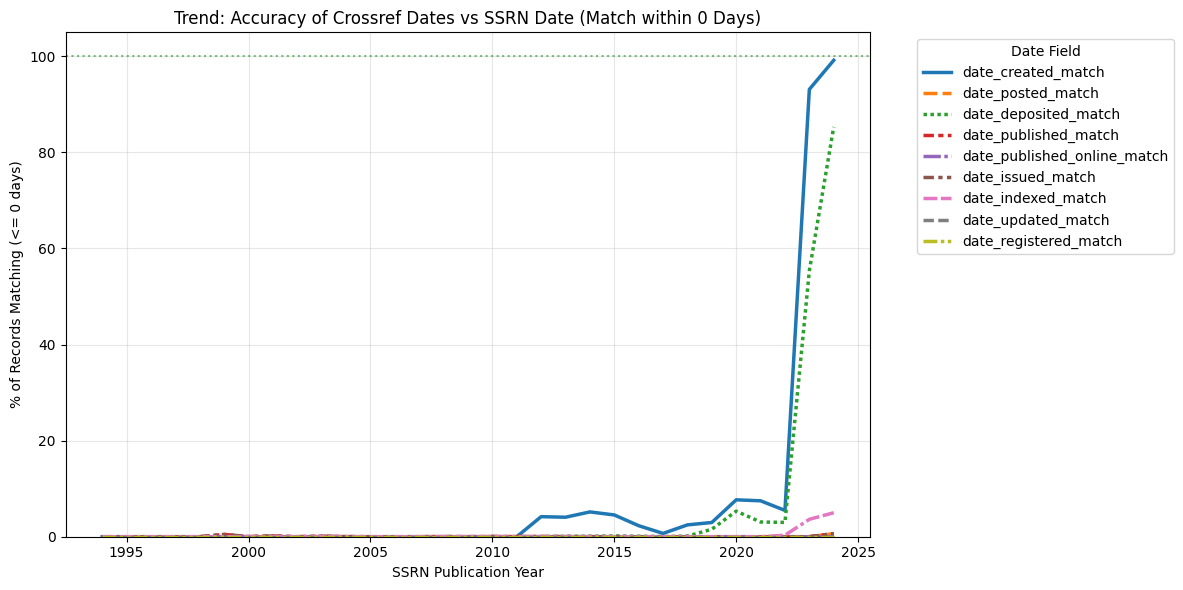

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Preparation ---
df = enriched[enriched.match_value.notna()].copy()

date_cols = [
    'date_created', 'date_posted', 'date_deposited', 
    'date_published', 'date_published_online',
    'date_issued', 'date_indexed', 'date_updated', 'date_registered'
]
target_col = 'date_posted_ssrn_best'  # Your "Gold Standard"

# Convert to datetime
for col in date_cols + [target_col]:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Extract Year
df['ssrn_year'] = df[target_col].dt.year

# --- 2. Build the Comprehensive Scorecard (Analysis A) ---
coverage_data = []
total_records = len(df)

for col in date_cols:
    # 1. Completeness
    valid_count = df[col].notna().sum()
    
    # 2. Get the subset where comparison is possible (Both dates exist)
    # We use this subset for all accuracy/lag stats
    valid_comparison = df.dropna(subset=[col, target_col])
    n_compare = len(valid_comparison)
    
    if n_compare > 0:
        # Calculate Difference in Days
        diffs = (valid_comparison[col] - valid_comparison[target_col]).dt.days
        
        # Exact Matches (0 Days)
        n_exact = (diffs == 0).sum()
        pct_exact = (n_exact / n_compare) * 100
        
        # Close Matches (<= 7 Days)
        n_close = (diffs.abs() <= 7).sum()
        pct_close = (n_close / n_compare) * 100
        
        # Lags
        avg_lag = diffs.mean()
        med_lag = diffs.median()
    else:
        n_exact = 0
        pct_exact = 0.0
        n_close = 0
        pct_close = 0.0
        avg_lag = np.nan
        med_lag = np.nan

    coverage_data.append({
        'Column': col,
        'Total Records': valid_count,
        'Completeness %': (valid_count / total_records) * 100,
        'Pairs Compared': n_compare,
        'Exact Match (N)': n_exact,
        'Exact Match %': pct_exact,
        'Within 7 Days (N)': n_close,
        'Within 7 Days %': pct_close,
        'Avg Lag (Days)': avg_lag,
        'Median Lag (Days)': med_lag
    })

# Create DataFrame and sort by "Within 7 Days %" to see the winner easily
coverage_df = pd.DataFrame(coverage_data).sort_values(by='Within 7 Days %', ascending=False)

print("--- Date Accuracy Scorecard ---")
# Rounding for cleaner display
print(coverage_df.round(2).to_string()) 


# --- 3. Plotting Trend (Analysis B) ---
# (User preference: plot Exact matches (day=0))
day = 0 

for col in date_cols:
    # Calculate match boolean for the plot specifically
    diff = (df[col] - df[target_col]).dt.days.abs()
    df[f'{col}_match'] = diff <= day

# Group by Year
trend_df = df.groupby('ssrn_year')[[f'{col}_match' for col in date_cols]].mean() * 100

# Filter Years
trend_df = trend_df.loc[1980:] 

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_df, linewidth=2.5)

plt.title(f"Trend: Accuracy of Crossref Dates vs SSRN Date (Match within {day} Days)")
plt.ylabel(f"% of Records Matching (<= {day} days)")
plt.xlabel("SSRN Publication Year")
plt.ylim(0, 105) 
plt.axhline(100, color='green', linestyle=':', alpha=0.5)
plt.legend(title="Date Field", bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside if crowded
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [24]:
coverage_df

,Column,Total Records,Completeness %,Pairs Compared,Exact Match (N),Exact Match %,Within 7 Days (N),Within 7 Days %,Avg Lag (Days),Median Lag (Days)
0,date_created,730023,100.000000,730023,175411,24.028147,473270,64.829464,362.350563,2.0
2,date_deposited,730023,100.000000,730023,106718,14.618444,228703,31.328191,1383.493338,385.0
6,date_indexed,730023,100.000000,730023,6669,0.913533,138632,18.990087,2038.509444,1159.0
1,date_posted,125366,17.172884,125366,156,0.124436,2531,2.018889,-167.810355,-166.0
4,date_published_online,45303,6.205695,45303,8,0.017659,669,1.476723,-163.919365,-158.0
3,date_published,730023,100.000000,730023,243,0.033287,7085,0.970517,-315.424866,-209.0
5,date_issued,730023,100.000000,730023,243,0.033287,7085,0.970517,-315.424866,-209.0
7,date_updated,0,0.000000,0,0,0.000000,0,0.000000,NaN,NaN
8,date_registered,0,0.000000,0,0,0.000000,0,0.000000,NaN,NaN


In [25]:
trend_df

,date_created_match,date_posted_match,date_deposited_match,date_published_match,date_published_online_match,date_issued_match,date_indexed_match,date_updated_match,date_registered_match
ssrn_year,,,,,,,,,
1994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1999,0.000000,0.000000,0.000000,0.477961,0.000000,0.477961,0.000000,0.0,0.0
2000,0.000000,0.000000,0.000000,0.028703,0.000000,0.028703,0.000000,0.0,0.0
2001,0.000000,0.000000,0.000000,0.156067,0.000000,0.156067,0.000000,0.0,0.0
2002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [26]:
enriched.publication_year_ssrn_best.value_counts()

publication_year_ssrn_best
2023.0    139908
2022.0    112005
2021.0     54034
2020.0     43468
2019.0     34608
2018.0     28771
2017.0     26406
2016.0     25555
2014.0     24946
2024.0     24894
2015.0     24857
2013.0     24439
2012.0     24091
2011.0     22518
2010.0     20764
2009.0     18537
2008.0     16900
2007.0     12373
2006.0     10114
2005.0      8754
2003.0      7206
2004.0      7040
2001.0      5126
2002.0      4934
2000.0      3484
1999.0      1883
1998.0      1545
1997.0       670
1996.0       176
1995.0        15
1994.0         2
Name: count, dtype: int64

In [27]:
enriched[enriched.match_value.isna()]

,record_id,server_name,doi,landing_page_url,title,authors_flat,publication_year,date_created,date_posted,date_deposited,date_published,date_published_online,date_issued,date_indexed,date_updated,date_registered,_doi_norm,_url_norm,ssrn_id,_ssrn_id_norm,match_key,match_value,date_posted_ssrn_best,publication_year_ssrn_best
2,crossref::10.2139/ssrn.681174,SSRN,10.2139/ssrn.681174,http://www.ssrn.com/abstract=681174,"Relational Formalism, Speech Act Theory and th...","Yovel, Jonathan E.",2005,2005-07-07,None,2007-02-13,2005-01-01,None,2005-01-01,2022-04-02,None,None,10.2139/ssrn.681174,http://www.ssrn.com/abstract=681174,681174,681174,<NA>,<NA>,NaT,<NA>
3,crossref::10.2139/ssrn.480691,SSRN,10.2139/ssrn.480691,http://www.ssrn.com/abstract=480691,Progressive Political Theory and Separation of...,"Claeys, Eric",2003,2005-07-07,None,2007-02-13,2003-01-01,None,2003-01-01,2022-04-06,None,None,10.2139/ssrn.480691,http://www.ssrn.com/abstract=480691,480691,480691,<NA>,<NA>,NaT,<NA>
4,crossref::10.2139/ssrn.161192,SSRN,10.2139/ssrn.161192,http://www.ssrn.com/abstract=161192,"The March on Washington, At Home and Abroad","Dudziak, Mary L.",1999,2005-07-07,None,2007-02-13,1999-01-01,None,1999-01-01,2022-04-06,None,None,10.2139/ssrn.161192,http://www.ssrn.com/abstract=161192,161192,161192,<NA>,<NA>,NaT,<NA>
6,crossref::10.2139/ssrn.686132,SSRN,10.2139/ssrn.686132,http://www.ssrn.com/abstract=686132,Do Takeover Auctions Induce a Winner's Curse?,"Boone, Audra L.; Mulherin, J. Harold Harold",2005,2005-07-07,None,2007-02-13,2005-01-01,None,2005-01-01,2022-04-06,None,None,10.2139/ssrn.686132,http://www.ssrn.com/abstract=686132,686132,686132,<NA>,<NA>,NaT,<NA>
8,crossref::10.2139/ssrn.141356,SSRN,10.2139/ssrn.141356,http://www.ssrn.com/abstract=141356,A Stochastic Convergence Model for Portfolio S...,"Puelz, Amy",1998,2005-08-19,None,2007-02-13,1998-01-01,None,1998-01-01,2022-04-05,None,None,10.2139/ssrn.141356,http://www.ssrn.com/abstract=141356,141356,141356,<NA>,<NA>,NaT,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258952,crossref::10.2139/ssrn.5996462,SSRN,10.2139/ssrn.5996462,https://www.ssrn.com/abstract=5996462,Student Views on EMI Effectiveness: A Q Method...,"Bùi, Trung Hoàng Minh",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996462,https://www.ssrn.com/abstract=5996462,5996462,5996462,<NA>,<NA>,NaT,<NA>
1258953,crossref::10.2139/ssrn.5996464,SSRN,10.2139/ssrn.5996464,https://www.ssrn.com/abstract=5996464,The role of institutional quality and geopolit...,"Uçaş, Muazez; Yaman, Serdar; Tunçel, Mert Baran",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996464,https://www.ssrn.com/abstract=5996464,5996464,5996464,<NA>,<NA>,NaT,<NA>
1258954,crossref::10.2139/ssrn.5996465,SSRN,10.2139/ssrn.5996465,https://www.ssrn.com/abstract=5996465,Nexus between financial inclusion and banking ...,"Aboubacar Mahaman, Abdoul Rachid; AZIBI, Jamel",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996465,https://www.ssrn.com/abstract=5996465,5996465,5996465,<NA>,<NA>,NaT,<NA>
1258955,crossref::10.2139/ssrn.5996467,SSRN,10.2139/ssrn.5996467,https://www.ssrn.com/abstract=5996467,FTIR spectroscopy coupled with multivariate an...,"Narkar, Shraddha; Sonekar, Sophiya; Das, Sera;...",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996467,https://www.ssrn.com/abstract=5996467,5996467,5996467,<NA>,<NA>,NaT,<NA>


In [28]:
enriched['date_created'] = pd.to_datetime(enriched['date_created'])
enriched[enriched.date_created >= '2024-01-01']


,record_id,server_name,doi,landing_page_url,title,authors_flat,publication_year,date_created,date_posted,date_deposited,date_published,date_published_online,date_issued,date_indexed,date_updated,date_registered,_doi_norm,_url_norm,ssrn_id,_ssrn_id_norm,match_key,match_value,date_posted_ssrn_best,publication_year_ssrn_best
744980,crossref::10.2139/ssrn.4680815,SSRN,10.2139/ssrn.4680815,https://www.ssrn.com/abstract=4680815,Dynamic Investigations on Cofe2o4@Co3o4 Nano-C...,"Zhang, Xihuan; EL JAOUHARI, ABDELHADI; Li, Chu...",2024,2024-01-01,2024-01-01,2024-01-01,2024-01-01,None,2024-01-01,2024-01-02,None,None,10.2139/ssrn.4680815,https://www.ssrn.com/abstract=4680815,4680815,4680815,<NA>,<NA>,NaT,<NA>
744981,crossref::10.2139/ssrn.4680817,SSRN,10.2139/ssrn.4680817,https://www.ssrn.com/abstract=4680817,Hydrogen-Bonded Frameworks Based on Hetero-Tri...,"Zhang, Jianjun; Zhou, Huajun Andrew; Lachgar,...",2024,2024-01-01,2024-01-01,2024-01-01,2024-01-01,None,2024-01-01,2024-01-02,None,None,10.2139/ssrn.4680817,https://www.ssrn.com/abstract=4680817,4680817,4680817,doi,10.2139/ssrn.4680817,2024-01-01,2024.0
744982,crossref::10.2139/ssrn.4680827,SSRN,10.2139/ssrn.4680827,https://www.ssrn.com/abstract=4680827,Operation Optimization of Combined Heat and Po...,"Huang, Yongyi; Ahmed, Shoaib; Ueda, Soichiro; ...",2024,2024-01-01,2024-01-01,2024-01-01,2024-01-01,None,2024-01-01,2024-01-01,None,None,10.2139/ssrn.4680827,https://www.ssrn.com/abstract=4680827,4680827,4680827,doi,10.2139/ssrn.4680827,2024-01-01,2024.0
744983,crossref::10.2139/ssrn.4680828,SSRN,10.2139/ssrn.4680828,https://www.ssrn.com/abstract=4680828,Valuation and Optimal Operation of Power Inves...,"Shao, Lingjie; Wu, Junle; Ma, Jinghan; Yu, She...",2024,2024-01-01,2024-01-01,2024-01-01,2024-01-01,None,2024-01-01,2024-01-01,None,None,10.2139/ssrn.4680828,https://www.ssrn.com/abstract=4680828,4680828,4680828,doi,10.2139/ssrn.4680828,2024-01-01,2024.0
744984,crossref::10.2139/ssrn.4680826,SSRN,10.2139/ssrn.4680826,https://www.ssrn.com/abstract=4680826,Spatio-Temporal Dynamics of Soil and Soil Orga...,"Santana, Derielsen Brandão; Rios, Guilherme ...",2024,2024-01-01,2024-01-01,2024-01-01,2024-01-01,None,2024-01-01,2024-01-01,None,None,10.2139/ssrn.4680826,https://www.ssrn.com/abstract=4680826,4680826,4680826,doi,10.2139/ssrn.4680826,2024-01-01,2024.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258952,crossref::10.2139/ssrn.5996462,SSRN,10.2139/ssrn.5996462,https://www.ssrn.com/abstract=5996462,Student Views on EMI Effectiveness: A Q Method...,"Bùi, Trung Hoàng Minh",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996462,https://www.ssrn.com/abstract=5996462,5996462,5996462,<NA>,<NA>,NaT,<NA>
1258953,crossref::10.2139/ssrn.5996464,SSRN,10.2139/ssrn.5996464,https://www.ssrn.com/abstract=5996464,The role of institutional quality and geopolit...,"Uçaş, Muazez; Yaman, Serdar; Tunçel, Mert Baran",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996464,https://www.ssrn.com/abstract=5996464,5996464,5996464,<NA>,<NA>,NaT,<NA>
1258954,crossref::10.2139/ssrn.5996465,SSRN,10.2139/ssrn.5996465,https://www.ssrn.com/abstract=5996465,Nexus between financial inclusion and banking ...,"Aboubacar Mahaman, Abdoul Rachid; AZIBI, Jamel",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996465,https://www.ssrn.com/abstract=5996465,5996465,5996465,<NA>,<NA>,NaT,<NA>
1258955,crossref::10.2139/ssrn.5996467,SSRN,10.2139/ssrn.5996467,https://www.ssrn.com/abstract=5996467,FTIR spectroscopy coupled with multivariate an...,"Narkar, Shraddha; Sonekar, Sophiya; Das, Sera;...",2025,2025-12-31,2025-01-01,2025-12-31,2025-01-01,None,2025-01-01,2025-12-31,None,None,10.2139/ssrn.5996467,https://www.ssrn.com/abstract=5996467,5996467,5996467,<NA>,<NA>,NaT,<NA>


In [ ]:
import requests
from ordered_set import OrderedSet
from bs4 import BeautifulSoup
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
import sys

def quickSoup(url):
    try:
        header = {}
        header['User-Agent'] = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'
        # page = requests.get(url, headers=header, timeout=10)
        soup = BeautifulSoup(requests.get(url, headers=header, timeout=10).content, 'html.parser')
        return(soup)
    except Exception:
        return(None)


def getPaper(url):
    try:
        article = quickSoup(url)
        t = article.get_text()
        if "The abstract you requested was not found" in t:
            return("{},".format(url))
        title = article.find('h1').get_text().replace("\n", "")
        test_list = OrderedSet(t.split("\n"))
        authors = test_list[0].replace(title, "").replace(" :: SSRN", "").replace(" by ", "").replace(", ", ":")
        # --- NEW DATE EXTRACTION LOGIC ---
        date_posted = "NA"
        date_revised = "NA"

        # Iterate through all lines of text once to find both dates
        for line in test_list:
            if "Posted: " in line:
                date_posted = line.replace("Posted: ", "").strip()
            elif "Last revised: " in line:
                date_revised = line.replace("Last revised: ", "").strip()
                
        text = t.split("Abstract\n")[1]
        abstract = "\"{}\"".format(text.split("Suggested Citation:")[0].replace("\n", ""))

        # get paper statistics
        stats = OrderedSet(article.find('div', attrs = {'class': 'box-paper-statics'}).get_text().split("\n"))
        views, dl, rank, refs = "", "", "", ""
        try:
            views = stats[stats.index('Abstract Views') + 1].strip().replace(",", "")
        except:
            pass
        try:
            dl = stats[stats.index('Downloads') + 1].strip().replace(",", "")
        except:
            pass
        try:
            rank = stats[stats.index('rank') + 1].strip().replace(",", "")
        except:
            pass
        try:
            refs = stats[stats.index('References') + 1].strip().replace(",", "")
        except:
            pass
        # results = [url, "\"{}\"".format(title), abstract, authors, date, views, dl, rank, refs]
        # return(",".join(results))
        results = [url, "\"{}\"".format(title), abstract, authors, date_posted, date_revised, views, dl, rank, refs]
        return(",".join(results))
    except:
        return("{},,,,,,,,".format(url))


def dummyscrape(start, stop):
    numWorkers = cpu_count() * 12
    print(numWorkers)
    p = Pool(numWorkers)
    linkList = ["https://papers.ssrn.com/sol3/papers.cfm?abstract_id=" + str(x) for x in range(start, stop)]

    papers = p.map(getPaper, linkList)
    p.terminate()
    p.join()
    writeString = "\n".join(papers)
    with open('test.csv', 'w+') as f:
        f.write(writeString)

def scrape(start, stop):
    numWorkers = cpu_count() * 12
    p = Pool(numWorkers)
    linkList = ["https://papers.ssrn.com/sol3/papers.cfm?abstract_id={}".format(str(x)) for x in range(start, stop)]

    papers = p.map(getPaper, linkList)
    p.terminate()
    p.join()
    writeString = "\n".join(papers)
    with open('ssrn-links.csv', 'a') as f:
        f.write(writeString)

if __name__ == "__main__":
    # import cProfile
    # import scraper
    # globals().update(vars(scraper))
    # sys.modules['__main__'] = scraper
    # dummyscrape(4000, 4100)
    breaks = [4500000 * x for x in range(450, 550)] #(179, 250)
    t = time.time()
    for i in range(len(breaks)-1):
        print(breaks[i])
        b = time.time()
        scrape(breaks[i], breaks[i+1])
        print("TIME FOR 10000: " + str(time.time() - b))
        print("TIME SINCE START: " + str(time.time() - t))

2025000000


In [ ]:
import requests
from ordered_set import OrderedSet
from bs4 import BeautifulSoup
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
import sys
import re

def quickSoup(url):
    try:
        header = {}
        # Using a standard browser User-Agent
        header['User-Agent'] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        
        # Added a small timeout to prevent hanging
        response = requests.get(url, headers=header, timeout=15)
        
        if response.status_code != 200:
            return None
            
        soup = BeautifulSoup(response.content, 'html.parser')
        return soup
    except Exception:
        return None


def getPaper(url):
    try:
        article = quickSoup(url)
        
        # If page failed to load
        if article is None:
            # Return empty row with error note
            return f"{url},ERROR_NETWORK,,,,,,,,,,"

        t = article.get_text()
        if "The abstract you requested was not found" in t:
            return f"{url},NOT_FOUND,,,,,,,,,,"

        # --- 1. TITLE ---
        try:
            title = article.find('h1').get_text(strip=True).replace("\n", "").replace('"', "'")
        except:
            title = "NA"

        # --- 2. AUTHORS ---
        # Using meta tags is much safer than splitting text
        try:
            meta_authors = article.find_all("meta", attrs={"name": "citation_author"})
            if meta_authors:
                authors = "; ".join([m['content'] for m in meta_authors])
            else:
                # Fallback to your original text splitting method if meta is missing
                test_list = OrderedSet(t.split("\n"))
                authors = test_list[0].replace(title, "").replace(" :: SSRN", "").replace(" by ", "").replace(", ", ":")
        except:
            authors = "NA"
        
        # Clean authors string (remove quotes that might break CSV)
        authors = authors.replace('"', "'")

        # --- 3. DOI (NEW) ---
        doi = "NA"
        try:
            # Best way: Look for the meta tag
            meta_doi = article.find("meta", attrs={"name": "citation_doi"})
            if meta_doi:
                doi = meta_doi['content']
            else:
                # Fallback: Look in text
                if "doi.org" in t:
                    # Simple find for doi string
                    # (This is basic, meta tag covers 99% of cases)
                    doi = "Found in text (parsing required)" 
        except:
            pass

        # --- 4. DATES (Posted & Revised) ---
        date_posted = "NA"
        date_revised = "NA"
        
        # Try Meta tag for Posted Date first (standard)
        try:
            meta_date = article.find("meta", attrs={"name": "citation_publication_date"})
            if meta_date:
                date_posted = meta_date['content']
        except:
            pass

        # Text scan for "Last revised" or fallback for Posted
        # We assume the dates are in the top 100 lines to speed up
        test_list = t.split("\n")[:100]
        for line in test_list:
            if date_posted == "NA" and "Posted: " in line:
                date_posted = line.replace("Posted: ", "").strip()
            if "Last revised: " in line:
                date_revised = line.replace("Last revised: ", "").strip()

        # --- 5. ABSTRACT ---
        try:
            # Safer split logic
            if "Abstract" in t:
                text_part = t.split("Abstract")[1]
                abstract_raw = text_part.split("Suggested Citation")[0]
                abstract = abstract_raw.replace("\n", " ").replace('"', "'").strip()
            else:
                abstract = "NA"
        except:
            abstract = "NA"

        # --- 6. STATS (Views, Downloads, Rank) ---
        views, dl, rank, refs = "NA", "NA", "NA", "NA"
        try:
            # We look for the specific box
            stats_box = article.find('div', attrs={'class': 'box-paper-statics'})
            if stats_box:
                stats_text = stats_box.get_text()
                
                # Using regex is safer than fixed index positions
                m_views = re.search(r"Abstract Views\s+([\d,]+)", stats_text)
                if m_views: views = m_views.group(1).replace(",", "")

                m_dl = re.search(r"Downloads\s+([\d,]+)", stats_text)
                if m_dl: dl = m_dl.group(1).replace(",", "")

                m_rank = re.search(r"Rank\s+([\d,]+)", stats_text)
                if m_rank: rank = m_rank.group(1).replace(",", "")
                
                m_refs = re.search(r"References\s+([\d,]+)", stats_text)
                if m_refs: refs = m_refs.group(1).replace(",", "")
        except:
            pass

        # --- RETURN RESULT ---
        # Note: We added DOI to the columns
        # Format: url, title, doi, authors, date_posted, date_revised, abstract, views, downloads, rank, refs
        results = [url, f'"{title}"', doi, f'"{authors}"', date_posted, date_revised, f'"{abstract}"', views, dl, rank, refs]
        return ",".join(results)

    except Exception as e:
        # Return a safe error row with the correct number of commas
        return f"{url},ERROR: {str(e)},,,,,,,,,,"


def scrape(start, stop):
    # SAFETY: Reduced to Avoid Ban. 
    # Do NOT increase this unless you have a commercial proxy.
    numWorkers = 4 
    
    p = Pool(numWorkers)
    linkList = ["https://papers.ssrn.com/sol3/papers.cfm?abstract_id={}".format(str(x)) for x in range(start, stop)]

    # Run the workers
    papers = p.map(getPaper, linkList)
    p.close() # 'close' is better than 'terminate' for clean exit
    p.join()
    
    writeString = "\n".join(papers)
    
    # Write to file (Make sure to write header once manually if starting fresh)
    with open('ssrn_results_with_doi.csv', 'a', encoding='utf-8') as f:
        f.write(writeString + "\n")

if __name__ == "__main__":
    # Example: Scrape IDs 20000 to 40000 (chunks of 1000)
    # Using smaller chunks is safer so you can save progress
    chunk_size = 1000 
    start_id = 4680815
    end_id = 6000000
    
    breaks = [x for x in range(start_id, end_id, chunk_size)]
    
    # Write Header First
    with open('ssrn_results_with_doi.csv', 'w', encoding='utf-8') as f:
        f.write("url,title,doi,authors,date_posted,date_revised,abstract,views,downloads,rank,refs\n")

    t = time.time()
    for i in range(len(breaks)-1):
        range_start = breaks[i]
        range_end = breaks[i+1]
        
        print(f"Scraping {range_start} to {range_end}...")
        
        b = time.time()
        scrape(range_start, range_end)
        
        print(f"Finished chunk in {time.time() - b:.2f} seconds")
        
        # SLEEP IS MANDATORY to avoid bans
        time.sleep(5)